In [3]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import scipy.stats as stats
import sklearn
from sklearn.linear_model import LinearRegression


bank_df = pd.read_csv("../../data/raw/bank_full.csv", delimiter=";")
loan_pred_df = pd.read_csv("../../data/raw/loan_prediction_full.csv")
churners_df = pd.read_csv("../../data/raw/bank_churn.csv")
nps_df = pd.read_csv("../../data/raw/NPSTimeSeries.csv")
ecommerce_df = pd.read_csv("../../data/raw/ecommerce_customer_data.csv")
loan_ir_df = pd.read_csv("../../data/raw/loan_interest.csv")
fake = Faker()
random.seed(3101)

# Initalising the DataFrame 
synthetic_data = pd.DataFrame(columns =['customer_id', 
                                        'age', 
                                        'job',
                                        'marital',
                                        'education',
                                        'default',
                                        'balance',
                                        'debt',
                                        'income',
                                        'tenure',
                                        'nps',
                                        'dependents',
                                        'customer_lifetime_value'])

synthetic_data.customer_id = [i for i in range(1, 4001)]
synthetic_data

,customer_id,age,job,marital,education,default,balance,debt,income,tenure,nps,dependents,customer_lifetime_value
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3996,3997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3997,3998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3998,3999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Balance

Synthesize 'balance' values, assuming 'balance' follows lognormal distribution.

In [4]:
# Assuming 'balance' has lognormal distribution, fit it to the distribution.
balance_data = bank_df['balance']
log_balance = np.log(balance_data[balance_data > 0])  

# Find the parameters that define the lognormal distribution
shape_balance, loc_balance, scale_balance = stats.lognorm.fit(balance_data[balance_data > 0], floc=0)
mu_balance = np.log(scale_balance) 
sigma_balance = shape_balance  

# Generate synthetic balance variable 
synthetic_balance = np.concatenate([
    -np.random.lognormal(mean=np.log(-balance_data[balance_data <= 0].mean()), sigma=np.std(np.log(-balance_data[balance_data < 0])) , size=1 + int(4000 * (len(balance_data[balance_data <= 0]) / len(balance_data)))),
    np.random.lognormal(mean=np.log(scale_balance), sigma=shape_balance, size=int(4000 * (len(balance_data[balance_data > 0]) / len(balance_data))))
])
synthetic_data["balance"] = synthetic_balance
synthetic_data["default"] = np.where(synthetic_balance < 0, 1, 0)
synthetic_data


,customer_id,age,job,marital,education,default,balance,debt,income,tenure,nps,dependents,customer_lifetime_value
0,1,NaN,NaN,NaN,NaN,1,-422.587014,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,1,-309.720757,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,1,-236.508089,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,1,-160.720567,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,1,-259.583973,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,NaN,NaN,NaN,NaN,0,103.379182,NaN,NaN,NaN,NaN,NaN,NaN
3996,3997,NaN,NaN,NaN,NaN,0,123.262467,NaN,NaN,NaN,NaN,NaN,NaN
3997,3998,NaN,NaN,NaN,NaN,0,542.498897,NaN,NaN,NaN,NaN,NaN,NaN
3998,3999,NaN,NaN,NaN,NaN,0,26.745535,NaN,NaN,NaN,NaN,NaN,NaN


# Age

In [5]:
# Analyze correlation between balance and age
age_data = bank_df['age']
corr, _ = stats.pearsonr(balance_data, age_data)

# Fit a linear regression model for age vs. log(balance)
log_balance = np.log(balance_data[balance_data > 0])
slope_age, intercept_age, r_value_age, p_value, std_err = stats.linregress(log_balance, age_data[balance_data > 0])

# Fit a normal distribution to the residuals
predicted_age = intercept_age + slope_age * log_balance
residuals = age_data[balance_data > 0] - predicted_age
residual_mu, residual_sigma = np.mean(residuals), np.std(residuals)

# Generate synthetic ages
synthetic_log_balance = np.log(np.abs(synthetic_balance)) * np.sign(synthetic_balance)
synthetic_age = intercept_age + slope_age * synthetic_log_balance + np.random.normal(loc=residual_mu, scale=residual_sigma, size=4000)

# Clip ages to min and max, impute outliers with mode
age_min, age_max = age_data.min(), age_data.max()
age_mode = age_data.mode()[0]
synthetic_age = np.where(synthetic_age < age_min, age_mode, synthetic_age)
synthetic_age = np.where(synthetic_age > age_max, age_mode, synthetic_age)
synthetic_age = np.round(synthetic_age).astype(int)

synthetic_data['age'] = synthetic_age
synthetic_data

,customer_id,age,job,marital,education,default,balance,debt,income,tenure,nps,dependents,customer_lifetime_value
0,1,32,NaN,NaN,NaN,1,-422.587014,NaN,NaN,NaN,NaN,NaN,NaN
1,2,28,NaN,NaN,NaN,1,-309.720757,NaN,NaN,NaN,NaN,NaN,NaN
2,3,27,NaN,NaN,NaN,1,-236.508089,NaN,NaN,NaN,NaN,NaN,NaN
3,4,32,NaN,NaN,NaN,1,-160.720567,NaN,NaN,NaN,NaN,NaN,NaN
4,5,31,NaN,NaN,NaN,1,-259.583973,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,39,NaN,NaN,NaN,0,103.379182,NaN,NaN,NaN,NaN,NaN,NaN
3996,3997,41,NaN,NaN,NaN,0,123.262467,NaN,NaN,NaN,NaN,NaN,NaN
3997,3998,25,NaN,NaN,NaN,0,542.498897,NaN,NaN,NaN,NaN,NaN,NaN
3998,3999,40,NaN,NaN,NaN,0,26.745535,NaN,NaN,NaN,NaN,NaN,NaN


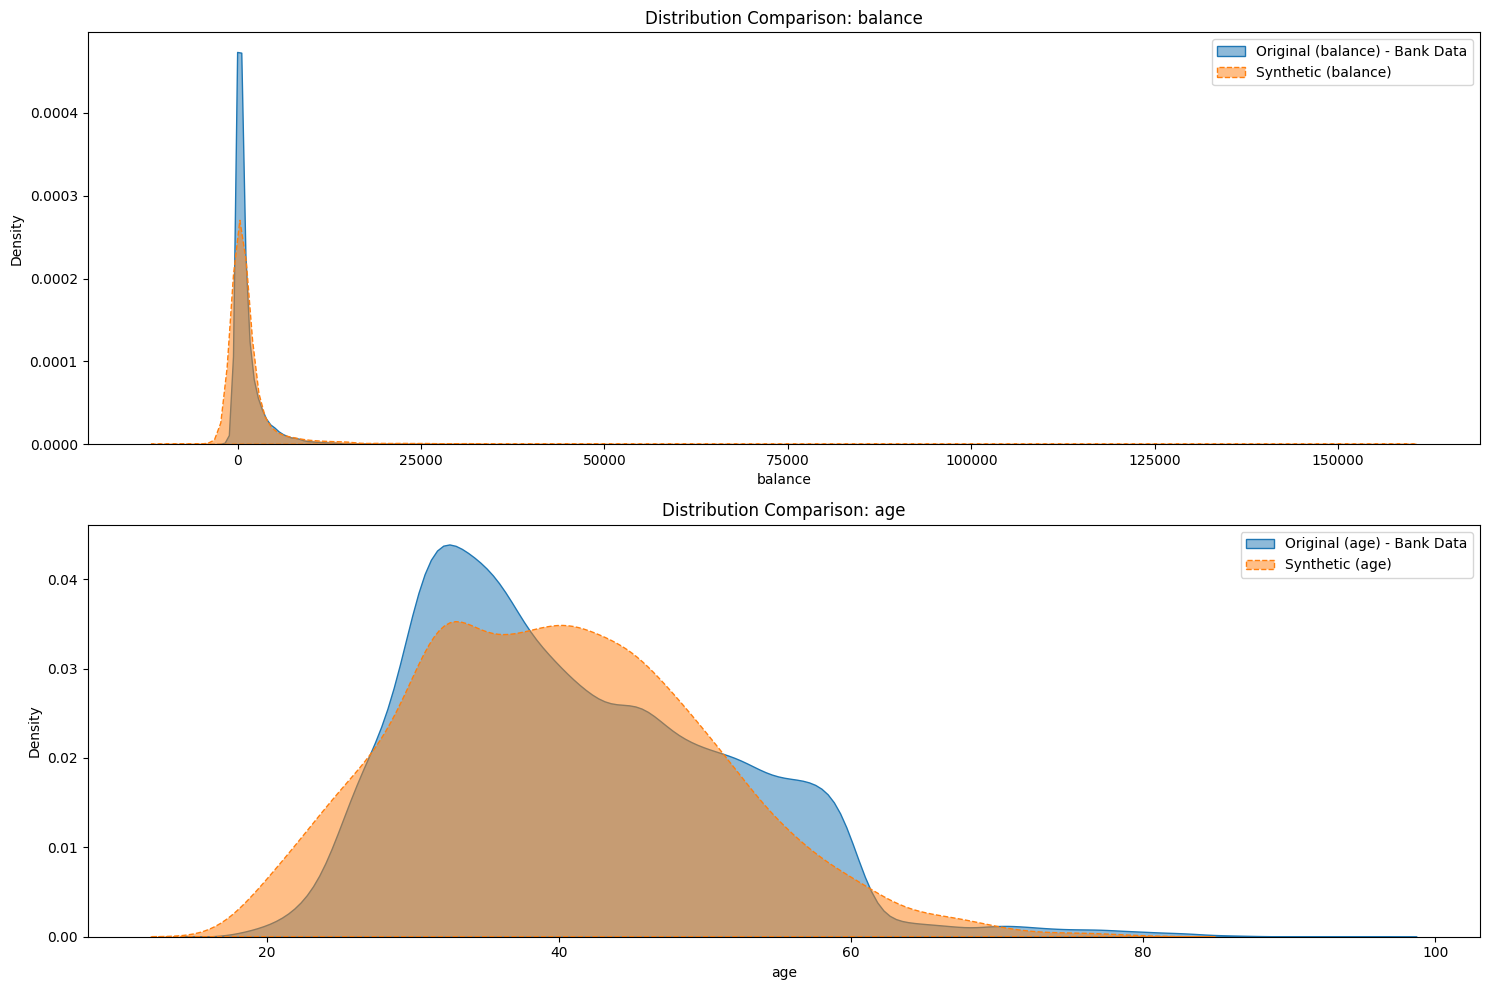

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# Define variables to compare
variables_to_compare = ['balance', 'age']

# Plot KDE distributions for each variable
plt.figure(figsize=(15, 5 * len(variables_to_compare)))

# KDE Distribution Comparison
for i, var in enumerate(variables_to_compare, 1):
    plt.subplot(len(variables_to_compare), 1, i)
    
    # Plot original distributions from bank and loan data (where applicable)
    if var in bank_df.columns:
        sns.kdeplot(bank_df[var], label=f"Original ({var}) - Bank Data", fill=True, alpha=0.5)
    if var in loan_pred_df.columns:
        sns.kdeplot(loan_pred_df[var], label=f"Original ({var}) - Loan Data", fill=True, alpha=0.5)
    
    # Plot synthetic distribution only if variable exists
    if var in synthetic_data.columns:
        sns.kdeplot(synthetic_data[var], label=f"Synthetic ({var})", fill=True, alpha=0.5, linestyle="--")
    else:
        print(f"Warning: {var} not found in synthetic_data!")

    plt.title(f"Distribution Comparison: {var}")
    plt.legend()

plt.tight_layout()
plt.show()

# Income
Assuming lognormal distribution for balance, synthesize 4000 income values. Assuming positve correlation between balance and income, add 'income' to the synthetic dataset by used rank-based matching with 'balance'.

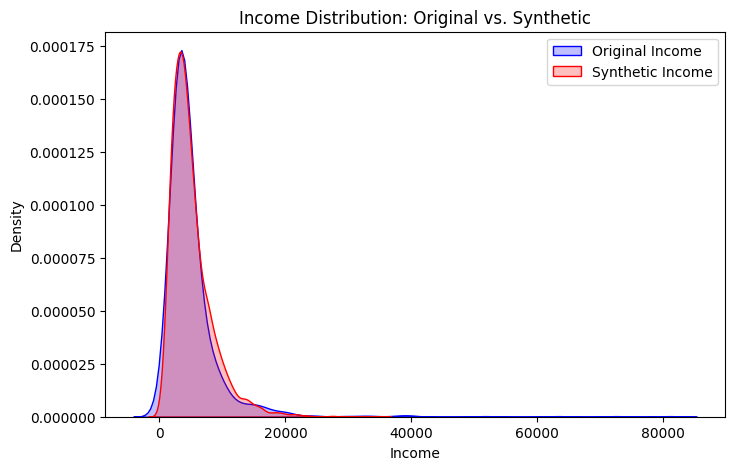

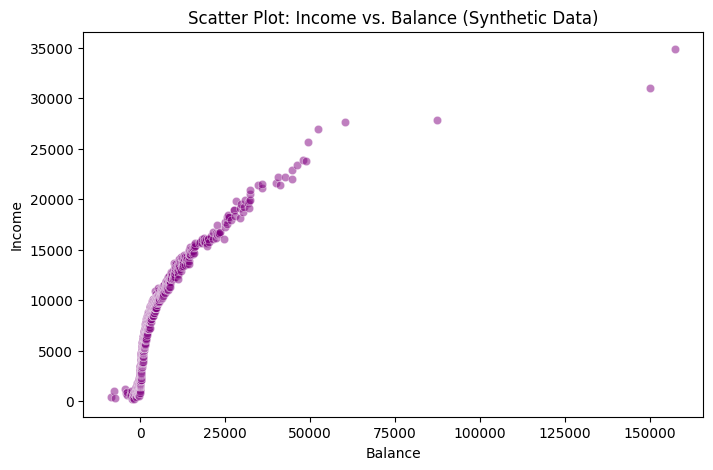

In [7]:

loan_pred_df = loan_pred_df.rename(columns={'ApplicantIncome': 'income'})
income_data = loan_pred_df['income'].dropna()
income_data = income_data[income_data > 0]

# Fit a lognormal distribution to income (if right-skewed)
shape_income, loc_income, scale_income = stats.lognorm.fit(income_data, floc=0)
mu_income = np.log(scale_income) 
sigma_income = shape_income      

balance_data = bank_df['balance']
age_data = bank_df['age']

synthetic_income = np.random.lognormal(mean=mu_income, sigma=sigma_income, size=4000)

# Assign ranked synthetic income to synthetic 'balance'
synthetic_data = synthetic_data.sort_values(by="balance").reset_index(drop=True)
sorted_synthetic_income = np.sort(synthetic_income)
synthetic_data.income = sorted_synthetic_income
income_noise = np.random.normal(scale=np.std(synthetic_income) * 0.1, size=4000) # add noise
synthetic_data.income = np.clip(synthetic_data.income + income_noise, 0, None)  # ensure non-negative income


# Income Distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(income_data, label="Original Income", color="blue", fill=True)
sns.kdeplot(synthetic_data['income'], label="Synthetic Income", color="red", fill=True)
plt.xlabel("Income")
plt.ylabel("Density")
plt.legend()
plt.title("Income Distribution: Original vs. Synthetic")
plt.show()

# Relationship Between Income and Balance
plt.figure(figsize=(8, 5))
sns.scatterplot(x=synthetic_data['balance'], y=synthetic_data['income'], alpha=0.5, color="purple")
plt.xlabel("Balance")
plt.ylabel("Income")
plt.title("Scatter Plot: Income vs. Balance (Synthetic Data)")
plt.show()


# Job
Based on the relationship between age and job, generate synthetic data for the variable 'job'.

First, compute probability that a customer has a certain job. Then, calculate the max and min age for each job in the original dataset (bank_full.csv), excluding any outliers. For each synthetic observation, check which jobs are valid for their age. Among these jobs, use the computed probabilities to randomly sample a job for the individual.

In [8]:
# Compute job frequency distribution per age group
job_age_counts = bank_df.groupby("job")["age"].count()
job_probabilities = job_age_counts / job_age_counts.sum()  

# Compute age bounds per job (excluding outliers)
def get_age_bounds(df):
    job_age_ranges = {}
    for job, subset in df.groupby("job"):
        q1, q3 = np.percentile(subset["age"], [25, 75])  
        iqr = q3 - q1  
        lower_bound = max(subset["age"].min(), q1 - 1.5 * iqr)  
        upper_bound = min(subset["age"].max(), q3 + 1.5 * iqr)  
        job_age_ranges[job] = (lower_bound, upper_bound)  
    return job_age_ranges


job_age_bounds = get_age_bounds(bank_df)

# Function to assign jobs based on weighted sampling
def assign_weighted_job(age):
    valid_jobs = [job for job, (min_age, max_age) in job_age_bounds.items() if min_age <= age <= max_age]
    
    if not valid_jobs:
        return "unknown"  # Default to unknown if no valid jobs exist
    
    job_probs = np.array([job_probabilities[job] for job in valid_jobs])
    job_probs = job_probs / job_probs.sum() 
    
    return np.random.choice(valid_jobs, p=job_probs)

# Assign jobs using weighted sampling
synthetic_data["job"] = synthetic_data["age"].apply(assign_weighted_job)


After generating the the 'job' variable based on its relationship with age as observed in the original dataset, we realised that some of the data points did not make sense. Since there were a lot of blue-collared workers, there was a higher probability that an individual was a blue-collared worker, even if their income was 40k+. Hence, we assumed a reasonable relationship between income and jobs, based on the average salary for each occupation.

In [9]:
job_income_ranges = {
    "management": (5000, 15000),
    "entrepreneur": (3000, 16000),
    "admin.": (3000, 8000),
    "technician": (2500, 7000),
    "blue-collar": (2000, 6000),
    "self-employed": (3000, 10000),
    "housemaid": (1000, 4000),
    "services": (1800, 5500),
    "retired": (500, 3000),
    "student": (500, 2500),
    "unemployed": (0, 2000),
    "unknown": (2000, 7000),
}

# Function to assign job based on income
def assign_job_based_on_income(income):
    possible_jobs = []
    for job, (min_income, max_income) in job_income_ranges.items():
        if min_income <= income <= max_income:
            possible_jobs.append(job)
    
    if possible_jobs:
        return np.random.choice(possible_jobs)  # Randomly assign one possible job
    else:
        return "unknown"  # If income is out of all ranges, set to 'unknown'

# Apply the function to assign jobs based on income
synthetic_data["job"] = synthetic_data["income"].apply(assign_job_based_on_income)

synthetic_data


,customer_id,age,job,marital,education,default,balance,debt,income,tenure,nps,dependents,customer_lifetime_value
0,307,42,unemployed,NaN,NaN,1,-8527.926260,NaN,381.378862,NaN,NaN,NaN,NaN
1,422,18,unemployed,NaN,NaN,1,-7712.394368,NaN,990.164235,NaN,NaN,NaN,NaN
2,399,20,unemployed,NaN,NaN,1,-7503.493359,NaN,321.683040,NaN,NaN,NaN,NaN
3,332,38,retired,NaN,NaN,1,-4586.432922,NaN,1182.780232,NaN,NaN,NaN,NaN
4,134,29,student,NaN,NaN,1,-4275.983195,NaN,790.478121,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3211,34,unknown,NaN,NaN,0,52226.063850,NaN,26917.975931,NaN,NaN,NaN,NaN
3996,2945,47,unknown,NaN,NaN,0,60275.644680,NaN,27681.285636,NaN,NaN,NaN,NaN
3997,2721,40,unknown,NaN,NaN,0,87355.679971,NaN,27819.719513,NaN,NaN,NaN,NaN
3998,2816,43,unknown,NaN,NaN,0,150062.592314,NaN,31009.535186,NaN,NaN,NaN,NaN


# Marital

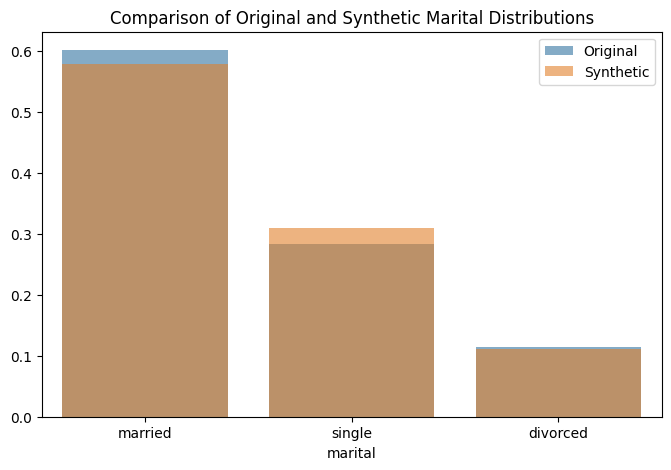

In [10]:
# Analyze marital distribution
marital_counts = bank_df['marital'].value_counts(normalize=True)
marital_choices = marital_counts.index.tolist()
marital_probs = marital_counts.values.tolist()

# Generate ages assuming a reasonable distribution
synthetic_age = np.random.randint(18, 70, size=4000)

# Generate marital status based on the distribution
synthetic_marital = np.random.choice(marital_choices, size=4000, p=marital_probs)
synthetic_marital[synthetic_data.age < 23] = 'single'

synthetic_data.marital = synthetic_marital

# Compare marital distributions
plt.figure(figsize=(8,5))
sns.barplot(x=marital_counts.index, y=marital_counts.values, alpha=0.6, label="Original")
sns.barplot(x=pd.Series(synthetic_data.marital).value_counts(normalize=True).index, 
            y=pd.Series(synthetic_data.marital).value_counts(normalize=True).values, alpha=0.6, label="Synthetic")
plt.legend()
plt.title("Comparison of Original and Synthetic Marital Distributions")
plt.show()



# Education

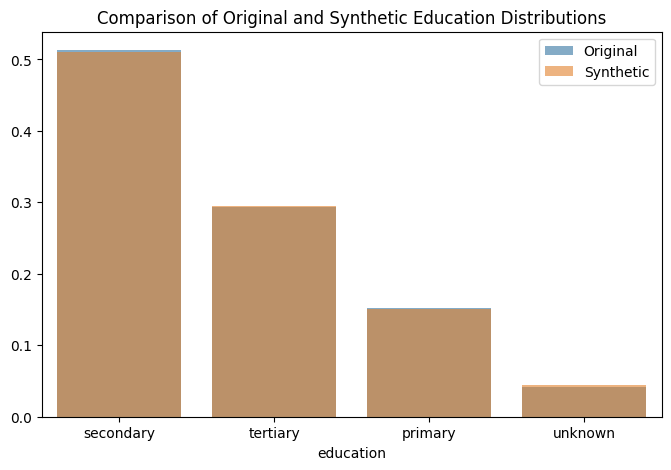

In [11]:
# Analyze education distribution
education_counts = bank_df['education'].value_counts(normalize=True)
education_choices = education_counts.index.tolist()
education_probs = education_counts.values.tolist()

# Generate education based on distribution
synthetic_education = np.random.choice(education_choices, size=4000, p=education_probs)
synthetic_education[synthetic_age < 18] = 'primary'
synthetic_data.education = synthetic_education

plt.figure(figsize=(8,5))
education_synthetic_counts = pd.Series(synthetic_education).value_counts(normalize=True)
sns.barplot(x=education_counts.index, y=education_counts.values, alpha=0.6, label="Original")
sns.barplot(x=education_synthetic_counts.index, y=education_synthetic_counts.values, alpha=0.6, label="Synthetic")
plt.legend()
plt.title("Comparison of Original and Synthetic Education Distributions")
plt.show()



# Tenure

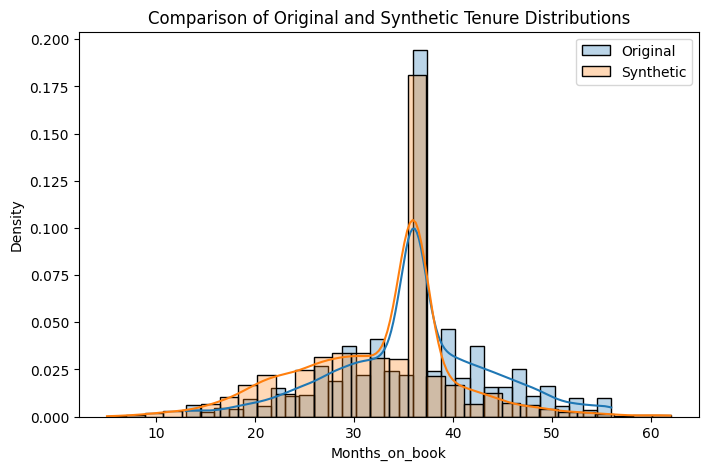

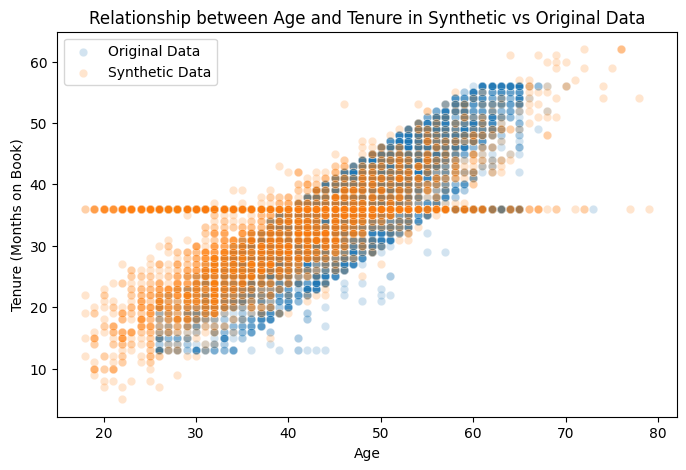

,customer_id,age,job,marital,education,default,balance,debt,income,tenure,nps,dependents,customer_lifetime_value
0,307,42,unemployed,married,secondary,1,-8527.926260,NaN,381.378862,36.0,NaN,NaN,NaN
1,422,18,unemployed,single,tertiary,1,-7712.394368,NaN,990.164235,36.0,NaN,NaN,NaN
2,399,20,unemployed,single,secondary,1,-7503.493359,NaN,321.683040,17.0,NaN,NaN,NaN
3,332,38,retired,married,primary,1,-4586.432922,NaN,1182.780232,36.0,NaN,NaN,NaN
4,134,29,student,single,secondary,1,-4275.983195,NaN,790.478121,22.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3211,34,unknown,divorced,secondary,0,52226.063850,NaN,26917.975931,24.0,NaN,NaN,NaN
3996,2945,47,unknown,married,secondary,0,60275.644680,NaN,27681.285636,36.0,NaN,NaN,NaN
3997,2721,40,unknown,married,tertiary,0,87355.679971,NaN,27819.719513,36.0,NaN,NaN,NaN
3998,2816,43,unknown,married,tertiary,0,150062.592314,NaN,31009.535186,39.0,NaN,NaN,NaN


In [12]:
random.seed(3101)
churners_df_age_tenure = churners_df.rename(columns={'Customer_Age': 'age'})[['age', 'Months_on_book']]
mode_tenure = churners_df_age_tenure['Months_on_book'].mode()[0]
mean_tenure = churners_df_age_tenure['Months_on_book'].mean()
std_tenure = churners_df_age_tenure['Months_on_book'].std()

# Generate tenure in the synthetic dataset based on synthetic age
age_tenure_slope, age_tenure_intercept = np.polyfit(churners_df_age_tenure['age'], churners_df_age_tenure['Months_on_book'], 1)
synthetic_tenure = (synthetic_data.age * age_tenure_slope) + age_tenure_intercept + np.random.normal(0, std_tenure * 0.5, size=4000)

synthetic_tenure = np.round(synthetic_tenure)
synthetic_tenure = np.clip(synthetic_tenure, a_min=0, a_max=None)

# Inject mode tenure into 30% of the data to preserve the original dataset’s mode
mode_injection_size = int(0.3 * 4000)
mode_indices = np.random.choice(4000, size=mode_injection_size, replace=False)
synthetic_tenure[mode_indices] = mode_tenure

synthetic_data.tenure = synthetic_tenure

# Compare tenure distributions
plt.figure(figsize=(8,5))
sns.histplot(churners_df_age_tenure['Months_on_book'], bins=30, kde=True, alpha=0.3, stat="density", label="Original")
sns.histplot(synthetic_data.tenure, bins=30, kde=True, alpha=0.3, stat="density", label="Synthetic")
plt.legend()
plt.title("Comparison of Original and Synthetic Tenure Distributions")
plt.show()

# Plot relationship between age and tenure in synthetic data with original dataset points
plt.figure(figsize=(8, 5))
sns.scatterplot(x=churners_df_age_tenure['age'], y=churners_df_age_tenure['Months_on_book'], alpha=0.2, label='Original Data')
sns.scatterplot(x=synthetic_data.age, y=synthetic_data.tenure, alpha=0.2, label='Synthetic Data')
plt.title("Relationship between Age and Tenure in Synthetic vs Original Data")
plt.xlabel("Age")
plt.ylabel("Tenure (Months on Book)")
plt.legend()
plt.show()

synthetic_data




# NPS

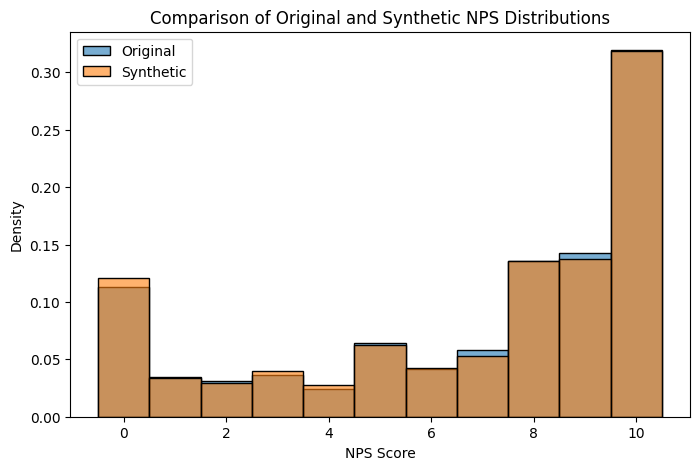

,customer_id,age,job,marital,education,default,balance,debt,income,tenure,nps,dependents,customer_lifetime_value
0,307,42,unemployed,married,secondary,1,-8527.926260,NaN,381.378862,36.0,10,NaN,NaN
1,422,18,unemployed,single,tertiary,1,-7712.394368,NaN,990.164235,36.0,7,NaN,NaN
2,399,20,unemployed,single,secondary,1,-7503.493359,NaN,321.683040,17.0,0,NaN,NaN
3,332,38,retired,married,primary,1,-4586.432922,NaN,1182.780232,36.0,8,NaN,NaN
4,134,29,student,single,secondary,1,-4275.983195,NaN,790.478121,22.0,10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3211,34,unknown,divorced,secondary,0,52226.063850,NaN,26917.975931,24.0,10,NaN,NaN
3996,2945,47,unknown,married,secondary,0,60275.644680,NaN,27681.285636,36.0,9,NaN,NaN
3997,2721,40,unknown,married,tertiary,0,87355.679971,NaN,27819.719513,36.0,8,NaN,NaN
3998,2816,43,unknown,married,tertiary,0,150062.592314,NaN,31009.535186,39.0,10,NaN,NaN


In [13]:
nps_values = nps_df['NPS']

# Compute the relative frequency of each unique NPS score as probabilities
nps_probabilities = nps_values.value_counts(normalize=True).sort_index()

# Generate synthetic NPS values using the observed probabilities
synthetic_nps = np.random.choice(nps_probabilities.index, size=4000, p=nps_probabilities.values)
synthetic_data.nps = synthetic_nps

# Plot comparison of original and synthetic NPS distributions
plt.figure(figsize=(8, 5))
sns.histplot(nps_values, bins=len(nps_probabilities), kde=False, stat="density", discrete=True, alpha=0.6, label="Original")
sns.histplot(synthetic_data.nps, bins=len(nps_probabilities), kde=False, stat="density", discrete=True, alpha=0.6, label="Synthetic")
plt.legend()
plt.title("Comparison of Original and Synthetic NPS Distributions")
plt.xlabel("NPS Score")
plt.ylabel("Density")
plt.show()

synthetic_data

# Dependents

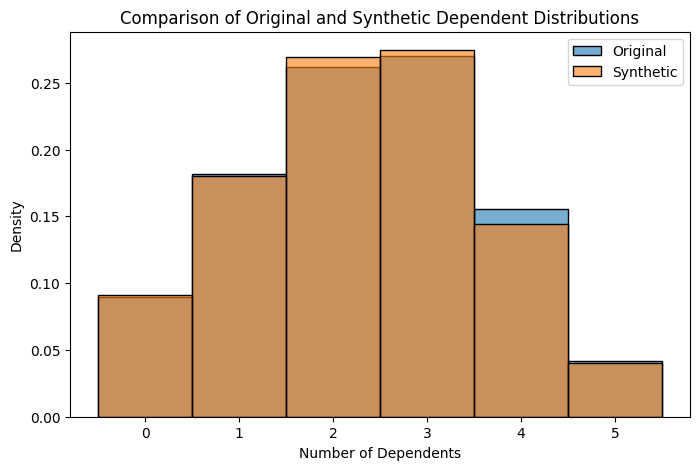

In [14]:
# Extract the distribution of Dependent_count
dependent_distribution = churners_df['Dependent_count'].value_counts(normalize=True).sort_index()

# Generate synthetic dependent counts using the observed distribution
synthetic_dependents = np.random.choice(dependent_distribution.index, size=4000, p=dependent_distribution.values)
synthetic_data.dependents = synthetic_dependents

# Plot comparison of original and synthetic dependents distributions
plt.figure(figsize=(8, 5))
sns.histplot(churners_df["Dependent_count"], bins=len(dependent_distribution), kde=False, stat="density", discrete=True, alpha=0.6, label="Original")
sns.histplot(synthetic_data.dependents, bins=len(dependent_distribution), kde=False, stat="density", discrete=True, alpha=0.6, label="Synthetic")
plt.legend()
plt.title("Comparison of Original and Synthetic Dependent Distributions")
plt.xlabel("Number of Dependents")
plt.ylabel("Density")
plt.show()


# Customer Lifetime Value

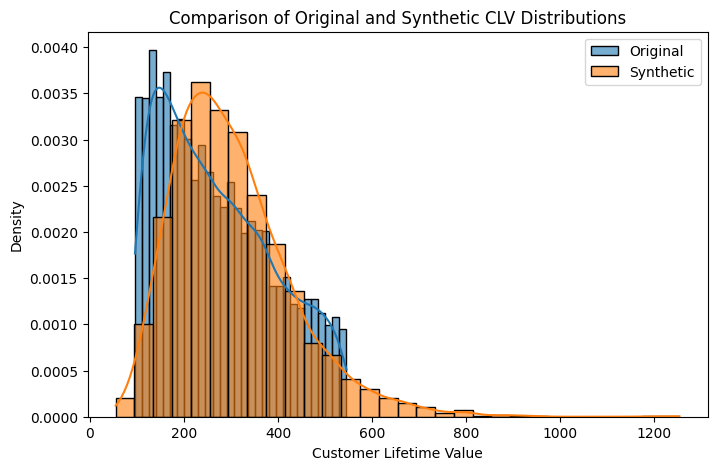

In [15]:
# Extract and filter the distribution of CLV
df_clv_filtered = ecommerce_df[(ecommerce_df["CustomerLifetimeValue"] >= ecommerce_df["CustomerLifetimeValue"].quantile(0.25)) &
                               (ecommerce_df["CustomerLifetimeValue"] <= ecommerce_df["CustomerLifetimeValue"].quantile(0.75))]
clv_mean = df_clv_filtered["CustomerLifetimeValue"].mean()
clv_std = df_clv_filtered["CustomerLifetimeValue"].std()

# Generate synthetic CLV values using a log-normal distribution
synthetic_clv = np.random.lognormal(mean=np.log(clv_mean), sigma=np.log(1 + clv_std / clv_mean), size=4000)

# Apply constraints based on reasonable assumptions:
# - Individuals with high income are likely to have higher CLV
# - Individuals with a balance < 0 may have lower CLV
# - Older individuals may have slightly higher CLV due to longer tenure
for i in range(len(synthetic_clv)):
    if synthetic_data.loc[i, 'income'] > synthetic_data['income'].median():
        synthetic_clv[i] *= np.random.uniform(1.1, 1.3) 
    if synthetic_data.loc[i, 'balance'] < 0:
        synthetic_clv[i] *= np.random.uniform(0.5, 0.9)
    if synthetic_data.loc[i, 'age'] > synthetic_data['income'].median():
        synthetic_clv[i] *= np.random.uniform(1.1, 1.4) 

# Round and clip values to ensure realism
synthetic_clv = np.round(synthetic_clv, 2)
synthetic_clv = np.clip(synthetic_clv, a_min=0, a_max=None)

# Add CLV column to synthetic dataset
synthetic_data.customer_lifetime_value = synthetic_clv

# Plot comparison of original and synthetic CLV distributions
plt.figure(figsize=(8, 5))
sns.histplot(df_clv_filtered["CustomerLifetimeValue"], bins=30, kde=True, stat="density", alpha=0.6, label="Original")
sns.histplot(synthetic_clv, bins=30, kde=True, stat="density", alpha=0.6, label="Synthetic")
plt.legend()
plt.title("Comparison of Original and Synthetic CLV Distributions")
plt.xlabel("Customer Lifetime Value")
plt.ylabel("Density")
plt.show()




# Debt

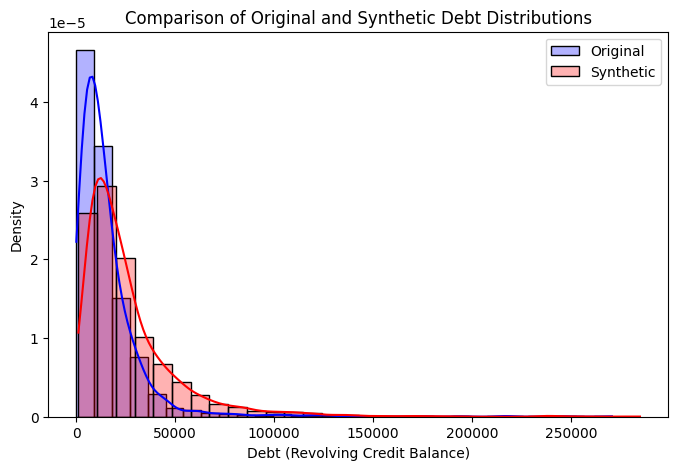

In [16]:
# Convert Revolving Credit Balance to numeric
loan_ir_df["Revolving.CREDIT.Balance"] = pd.to_numeric(loan_ir_df["Revolving.CREDIT.Balance"], errors="coerce")

df_rcb_filtered = loan_ir_df[loan_ir_df["Revolving.CREDIT.Balance"].notna()]
rcb_mean = df_rcb_filtered["Revolving.CREDIT.Balance"].mean()
rcb_std = df_rcb_filtered["Revolving.CREDIT.Balance"].std()

# Generate synthetic debt values using a log-normal distribution
synthetic_debt = np.random.lognormal(mean=np.log(rcb_mean), sigma=np.log(1 + rcb_std / rcb_mean), size=4000)

# Apply constraints based on reasonable assumptions:
# - Higher-income individuals tend to have higher debt
# - Individuals with negative balance are more likely to have higher debt
# - Older individuals may have lower debt due to financial stability
for i in range(len(synthetic_debt)):
    if synthetic_data.loc[i, 'income'] > synthetic_data['income'].median():
        synthetic_debt[i] *= np.random.uniform(1.2, 1.6)  
    if synthetic_data.loc[i, 'balance'] < 0:
        synthetic_debt[i] *= np.random.uniform(1.3, 1.7)  
    if synthetic_data.loc[i, 'age'] > 50:
        synthetic_debt[i] *= np.random.uniform(0.6, 0.9)  

synthetic_debt = np.round(synthetic_debt, 2)
synthetic_debt = np.clip(synthetic_debt, a_min=0, a_max=None)

synthetic_data["debt"] = synthetic_debt.flatten()


# Plot comparison of original and synthetic Revolving Credit Balance distributions with different colors
plt.figure(figsize=(8, 5))
sns.histplot(df_rcb_filtered["Revolving.CREDIT.Balance"], bins=30, kde=True, stat="density", alpha=0.3, label="Original", color='blue')
sns.histplot(synthetic_data.debt, bins=30, kde=True, stat="density", alpha=0.3, label="Synthetic", color='red')
plt.legend()
plt.title("Comparison of Original and Synthetic Debt Distributions")
plt.xlabel("Debt (Revolving Credit Balance)")
plt.ylabel("Density")
plt.show()




In [17]:
# Convert data types according to the schema
synthetic_data = synthetic_data.astype({
    "customer_id": "int64",
    "age": "int64",
    "job": "string",
    "marital": "string",
    "education": "string",
    "default": "int64",
    "tenure": "int64",
    "nps": "int64",
    "dependents": "int64", 
    "customer_lifetime_value": "float64" 
})

# Round monetary values to 2 decimal places and set as float
monetary_columns = ["balance", "debt", "income"]
synthetic_data[monetary_columns] = synthetic_data[monetary_columns].round(2).astype("float64")


In [18]:
synthetic_data

,customer_id,age,job,marital,education,default,balance,debt,income,tenure,nps,dependents,customer_lifetime_value
0,307,42,unemployed,married,secondary,1,-8527.93,15905.07,381.38,36,10,0,127.23
1,422,18,unemployed,single,tertiary,1,-7712.39,41772.07,990.16,36,7,2,190.76
2,399,20,unemployed,single,secondary,1,-7503.49,6633.42,321.68,17,0,4,142.54
3,332,38,retired,married,primary,1,-4586.43,6474.59,1182.78,36,8,4,348.80
4,134,29,student,single,secondary,1,-4275.98,65609.41,790.48,22,10,3,172.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3211,34,unknown,divorced,secondary,0,52226.06,5237.28,26917.98,24,10,3,231.39
3996,2945,47,unknown,married,secondary,0,60275.64,6592.01,27681.29,36,9,4,377.09
3997,2721,40,unknown,married,tertiary,0,87355.68,58672.48,27819.72,36,8,3,264.17
3998,2816,43,unknown,married,tertiary,0,150062.59,76395.73,31009.54,39,10,0,218.65


In [19]:
synthetic_data
synthetic_data.to_csv("../data/processed/customer.csv", index=False)

OSError: Cannot save file into a non-existent directory: '..\data\processed'

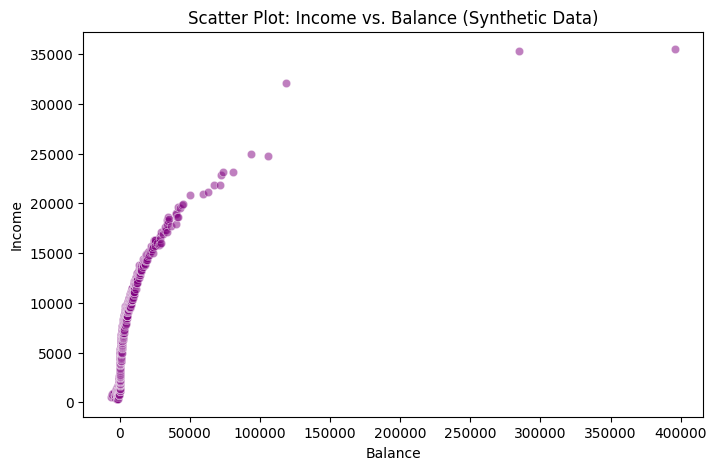

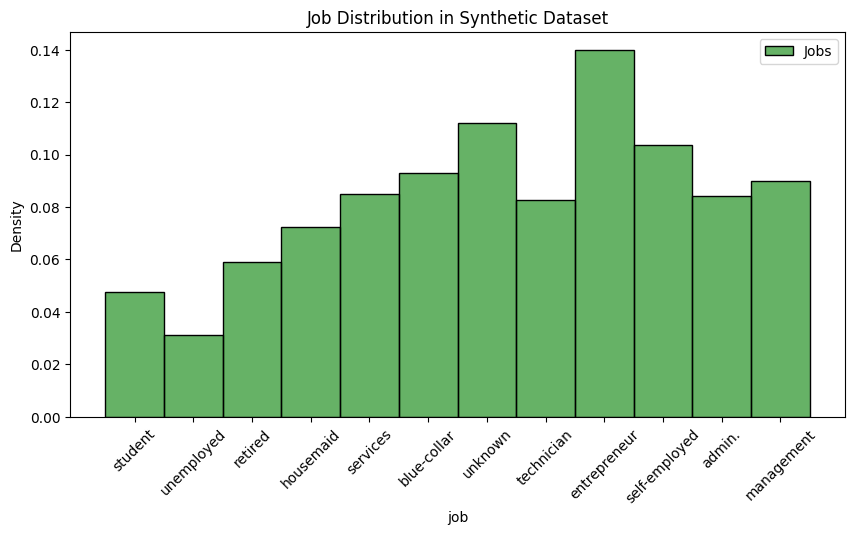

In [ ]:
customers = pd.read_csv("../../data/processed/customer.csv")

plt.figure(figsize=(8, 5))
sns.scatterplot(x=customers['balance'], y=customers['income'], alpha=0.5, color="purple")
plt.xlabel("Balance")
plt.ylabel("Income")
plt.title("Scatter Plot: Income vs. Balance (Synthetic Data)")
plt.show()

# Plot the distribution of 'job' in the new dataset
plt.figure(figsize=(10, 5))
sns.histplot(customers["job"], stat="density", alpha=0.6, color="green", label="Jobs")
plt.xticks(rotation=45)
plt.legend()
plt.title("Job Distribution in Synthetic Dataset")
plt.show()
